In [20]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("dataset.csv")

df["order_date"] = pd.to_datetime(df["order_date"])
df

,id,order_date,user_id
0,114363,2019-01-01,53424
1,114364,2019-01-01,77226
2,114366,2019-01-01,67632
3,114369,2019-01-01,63167
4,114370,2019-01-01,32047
...,...,...,...
192908,326833,2019-12-27,131981
192909,326834,2019-12-27,54449
192910,326835,2019-12-27,52375
192911,326837,2019-12-27,118653


In [21]:
# tambah kolom order month dengan format YYYY-MM (misal 2019-03)
df["order_month"] = df["order_date"].dt.to_period("M").astype(str)
df[["user_id", "order_date", "order_month"]]

,user_id,order_date,order_month
0,53424,2019-01-01,2019-01
1,77226,2019-01-01,2019-01
2,67632,2019-01-01,2019-01
3,63167,2019-01-01,2019-01
4,32047,2019-01-01,2019-01
...,...,...,...
192908,131981,2019-12-27,2019-12
192909,54449,2019-12-27,2019-12
192910,52375,2019-12-27,2019-12
192911,118653,2019-12-27,2019-12


In [22]:
# cari kapan pertama kali setiap user order
first_order = (
    df.groupby("user_id")["order_date"]
      .min()
      .reset_index()
)

# ubah jadi bulan
first_order["acq_month"] = first_order["order_date"].dt.to_period("M").astype(str)

# kita cuma butuh user_id dan acq_month
first_order = first_order[["user_id", "acq_month"]]
first_order

,user_id,acq_month
0,6,2019-06
1,9,2019-06
2,12,2019-01
3,82,2019-05
4,98,2019-01
...,...,...
28126,139507,2019-12
28127,139530,2019-12
28128,139541,2019-12
28129,139596,2019-12


In [23]:
# merged data
df = df.merge(first_order, on="user_id", how="left")
df[["user_id", "order_date", "order_month", "acq_month"]]

,user_id,order_date,order_month,acq_month
0,53424,2019-01-01,2019-01,2019-01
1,77226,2019-01-01,2019-01,2019-01
2,67632,2019-01-01,2019-01,2019-01
3,63167,2019-01-01,2019-01,2019-01
4,32047,2019-01-01,2019-01,2019-01
...,...,...,...,...
192908,131981,2019-12-27,2019-12,2019-11
192909,54449,2019-12-27,2019-12,2019-12
192910,52375,2019-12-27,2019-12,2019-01
192911,118653,2019-12-27,2019-12,2019-09


In [24]:
# ubah ke Period agar bisa dihitung selisih bulannya
df["order_month_period"] = df["order_date"].dt.to_period("M")
df["acq_month_period"] = pd.PeriodIndex(df["acq_month"], freq="M")

# selisih bulan: 0 = bulan akuisisi, 1 = bulan berikutnya, dst.
df["month_offset"] = (df["order_month_period"] - df["acq_month_period"]).apply(lambda x: x.n)

df[["user_id", "order_date", "acq_month", "order_month_period", "month_offset"]]

,user_id,order_date,acq_month,order_month_period,month_offset
0,53424,2019-01-01,2019-01,2019-01,0
1,77226,2019-01-01,2019-01,2019-01,0
2,67632,2019-01-01,2019-01,2019-01,0
3,63167,2019-01-01,2019-01,2019-01,0
4,32047,2019-01-01,2019-01,2019-01,0
...,...,...,...,...,...
192908,131981,2019-12-27,2019-11,2019-12,1
192909,54449,2019-12-27,2019-12,2019-12,0
192910,52375,2019-12-27,2019-01,2019-12,11
192911,118653,2019-12-27,2019-09,2019-12,3


In [25]:
cohort_sizes = (
    first_order.groupby("acq_month")["user_id"]
               .nunique()
               .rename("cohort_size")
               .reset_index()
)
cohort_sizes

,acq_month,cohort_size
0,2019-01,4520
1,2019-02,2466
2,2019-03,2662
3,2019-04,2074
4,2019-05,2616
5,2019-06,2802
6,2019-07,3234
7,2019-08,2080
8,2019-09,1697
9,2019-10,1622


In [26]:
# berapa user aktif
cohort_data = (
    df.groupby(["acq_month", "month_offset"])["user_id"]
      .nunique()
      .reset_index()
      .rename(columns={"user_id": "active_users"})
)

cohort_data = cohort_data.merge(cohort_sizes, on="acq_month", how="left")

# hitung retention rate
cohort_data["retention_rate"] = cohort_data["active_users"] / cohort_data["cohort_size"]

cohort_data

,acq_month,month_offset,active_users,cohort_size,retention_rate
0,2019-01,0,4520,4520,1.000000
1,2019-01,1,2093,4520,0.463053
2,2019-01,2,1673,4520,0.370133
3,2019-01,3,1342,4520,0.296903
4,2019-01,4,1066,4520,0.235841
...,...,...,...,...,...
73,2019-10,1,633,1622,0.390259
74,2019-10,2,405,1622,0.249692
75,2019-11,0,1442,1442,1.000000
76,2019-11,1,527,1442,0.365465


In [27]:
# jadikan matriks
retention_matrix = cohort_data.pivot(
    index="acq_month",
    columns="month_offset",
    values="retention_rate"
).fillna(0)

retention_matrix

month_offset,0,1,2,3,4,5,6,7,8,9,10,11
acq_month,,,,,,,,,,,,
2019-01,1.0,0.463053,0.370133,0.296903,0.235841,0.265708,0.258407,0.202876,0.168805,0.144469,0.138496,0.107522
2019-02,1.0,0.415247,0.247770,0.195864,0.200324,0.188159,0.140714,0.114761,0.102595,0.094079,0.070965,0.000000
2019-03,1.0,0.348234,0.220887,0.209617,0.194591,0.143877,0.123967,0.116078,0.097671,0.081142,0.000000,0.000000
2019-04,1.0,0.341851,0.260849,0.229990,0.160559,0.127290,0.112343,0.098843,0.081003,0.000000,0.000000,0.000000
2019-05,1.0,0.300459,0.214067,0.140673,0.111621,0.094801,0.074541,0.061544,0.000000,0.000000,0.000000,0.000000
2019-06,1.0,0.428266,0.238044,0.175589,0.152748,0.133476,0.105282,0.000000,0.000000,0.000000,0.000000,0.000000
2019-07,1.0,0.419295,0.278912,0.225417,0.188621,0.150588,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-08,1.0,0.420192,0.289423,0.228846,0.189904,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-09,1.0,0.397761,0.278727,0.210961,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


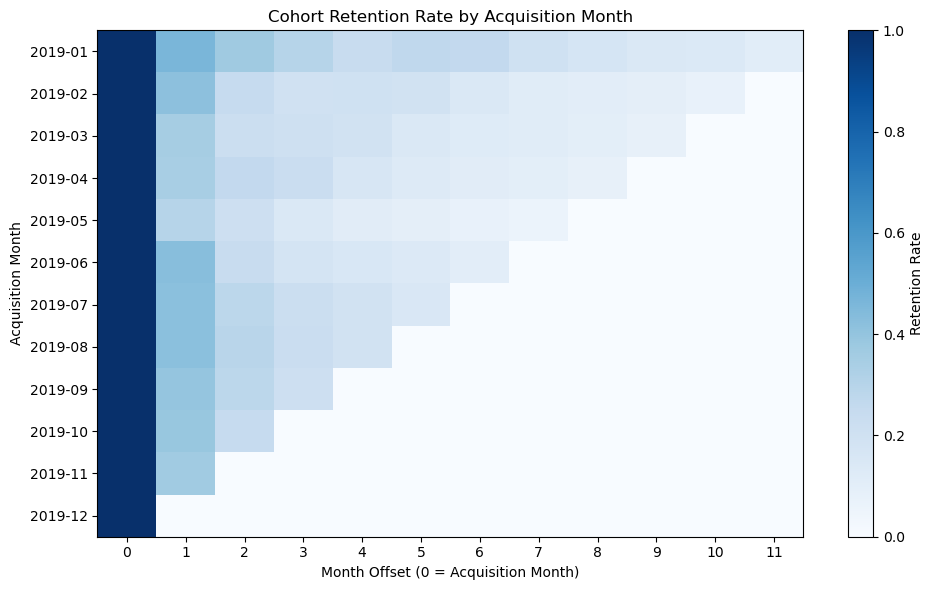

In [28]:
# heatmap
plt.figure(figsize=(10, 6))

plt.imshow(retention_matrix, aspect="auto", cmap="Blues", interpolation="nearest")
plt.colorbar(label="Retention Rate")

# label sumbu Y = acquisition month
plt.yticks(
    ticks=range(len(retention_matrix.index)),
    labels=retention_matrix.index
)

# label sumbu X = month offset (0,1,2,...)
plt.xticks(
    ticks=range(len(retention_matrix.columns)),
    labels=retention_matrix.columns
)

plt.xlabel("Month Offset (0 = Acquisition Month)")
plt.ylabel("Acquisition Month")
plt.title("Cohort Retention Rate by Acquisition Month")

plt.tight_layout()
plt.show()